In [1]:
'''实战 Kaggle 比赛：预测房价'''

'实战 Kaggle 比赛：预测房价'

In [2]:
# 实现几个函数来方便下载数据
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [5]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
# 使用pandas读入并处理数据

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)
train_data.head()

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
'''iloc是取數字順序的 index'''
# 前四个和最后两个特征，以及相应标签
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])


# 在每个样本中，第一个特征是ID， 我们将其从数据集中删除
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print('\n', all_features.iloc[0:4,[0, 1, 2, 3, -3, -2, -1]])
print(all_features.shape)

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000

    MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml
(2919, 79)


In [9]:
# 将所有缺失的值替换为相应特征的平均值。 通过将特征重新缩放到零均值和单位方差来标准化数据

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print(numeric_features)


# normalize feature
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
print(all_features[numeric_features].iloc[0:5, [0, 1, -2, -1]])

all_features[numeric_features] = all_features[numeric_features].fillna(0)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
   MSSubClass  LotFrontage    MoSold    YrSold
0    0.067320    -0.184443 -1.551918  0.157619
1   -0.873466     0.458096 -0.446848 -0.602858
2    0.067320    -0.055935  1.026577  0.157619
3    0.302516    -0.398622 -1.551918 -1.363335
4    0.067320     0.629439  2.131647  0.157619


In [10]:
# 处理离散值。 我们用一次one-hot encoding替换它们

all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.iloc[0:4,[0, 1, 2, -3, -2, -1]])

   MSSubClass  LotFrontage   LotArea  SaleCondition_Normal  \
0    0.067320    -0.184443 -0.217841                  True   
1   -0.873466     0.458096 -0.072032                  True   
2    0.067320    -0.055935  0.137173                  True   
3    0.302516    -0.398622 -0.078371                 False   

   SaleCondition_Partial  SaleCondition_nan  
0                  False              False  
1                  False              False  
2                  False              False  
3                  False              False  


In [11]:
# True & false 變成 0 & 1
all_features = all_features * 1
print('\n', all_features.iloc[0:4,[0, 1, 2, -3, -2, -1]])

all_features.shape


    MSSubClass  LotFrontage   LotArea  SaleCondition_Normal  \
0    0.067320    -0.184443 -0.217841                     1   
1   -0.873466     0.458096 -0.072032                     1   
2    0.067320    -0.055935  0.137173                     1   
3    0.302516    -0.398622 -0.078371                     0   

   SaleCondition_Partial  SaleCondition_nan  
0                      0                  0  
1                      0                  0  
2                      0                  0  
3                      0                  0  


(2919, 330)

In [12]:
# 从pandas格式中提取NumPy格式，并将其转换为张量表示

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)

In [13]:
# 训练

loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [14]:
# 我们更关心相对误差 (𝑦−𝑦̂)/𝑦， 解决这个问题的一种方法是用价格预测的对数来衡量差异

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [15]:
# 我们的训练函数将借助Adam优化器

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [16]:
# K折交叉验证

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [17]:
# 返回训练和验证误差的平均值

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.170890, valid log rmse 0.156333
fold 2, train log rmse 0.162393, valid log rmse 0.189046
fold 3, train log rmse 0.163580, valid log rmse 0.168093
fold 4, train log rmse 0.168623, valid log rmse 0.154662
fold 5, train log rmse 0.162903, valid log rmse 0.182893
5-折验证: 平均训练log rmse: 0.165678, 平均验证log rmse: 0.170205


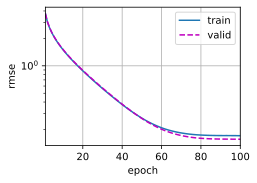

In [18]:
# 模型选择

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

train log rmse 0.162480


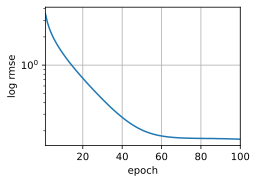

In [19]:
# 提交你的Kaggle预测

def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [20]:
'''课程竞赛：加州2020年房价预测'''

'课程竞赛：加州2020年房价预测'

In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l



train_datas = pd.read_csv('/Users/tinganwang/Desktop/train1.csv')
test_datas = pd.read_csv('/Users/tinganwang/Desktop/test.csv')

print(train_datas.shape)
print(test_datas.shape)


(47439, 41)
(31626, 40)


In [46]:
# 先合併
'''iloc是取數字順序的 index'''

# 前四个和最后两个特征，以及相应标签
print(train_datas.iloc[0:4,[0, 1, 2, -2, -1]])
#print('\n',test_datas.iloc[0:4,[0, 1, 2, -2, -1]])


# 在每个样本中，第一个特征是ID， 我们将其从数据集中删除
all_feature = pd.concat((train_datas.iloc[:, 1:-1], test_datas.iloc[:, 1:]))
print(all_feature.iloc[0:4,[0,1,-2,-1]])
print(all_feature.shape)

   Id            Address  SoldPrice    Zip State
0   0        540 Pine Ln  3825000.0  94022    CA
1   1     1727 W 67th St   505000.0  90047    CA
2   2     28093 Pine Ave   140000.0  95375    CA
3   3  10750 Braddock Dr  1775000.0  90230    CA
             Address  SoldPrice    Zip State
0        540 Pine Ln  3825000.0  94022   NaN
1     1727 W 67th St   505000.0  90047   NaN
2     28093 Pine Ave   140000.0  95375   NaN
3  10750 Braddock Dr  1775000.0  90230   NaN
(79065, 40)


In [47]:
# check categorical feature
all_feature.info()                   # 21個categorical feature, lol

# check missing values
print(all_feature.isnull().sum())    # many missing values, lol

<class 'pandas.core.frame.DataFrame'>
Index: 79065 entries, 0 to 31625
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Address                      79065 non-null  object 
 1   SoldPrice                    47439 non-null  float64
 2   Summary                      78219 non-null  object 
 3   Type                         79065 non-null  object 
 4   Year built                   77123 non-null  float64
 5   Heating                      66858 non-null  object 
 6   Cooling                      48921 non-null  object 
 7   Parking                      76740 non-null  object 
 8   Lot                          56076 non-null  float64
 9   Bedrooms                     74467 non-null  object 
 10  Bathrooms                    73655 non-null  float64
 11  Full bathrooms               66137 non-null  float64
 12  Total interior livable area  75187 non-null  float64
 13  Total spaces         

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

numerical_feature = all_feature.dtypes[all_feature.dtypes != 'object'].index
print(numerical_feature)


# normalize features
normalizer = StandardScaler()
all_feature[numerical_feature] = normalizer.fit_transform(all_feature[numerical_feature])



# 将所有missing values替换为相应的numerical feature的平均值
mean_val = all_feature[numerical_feature].mean()
all_feature[numerical_feature] = all_feature[numerical_feature].fillna(mean_val)
print(all_feature[numerical_feature].isnull().sum())

Index(['SoldPrice', 'Year built', 'Lot', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School Score', 'Middle School Distance', 'High School Score',
       'High School Distance', 'Tax assessed value', 'Annual tax amount',
       'Listed Price', 'Last Sold Price', 'Zip'],
      dtype='object')
SoldPrice                      0
Year built                     0
Lot                            0
Bathrooms                      0
Full bathrooms                 0
Total interior livable area    0
Total spaces                   0
Garage spaces                  0
Elementary School Score        0
Elementary School Distance     0
Middle School Score            0
Middle School Distance         0
High School Score              0
High School Distance           0
Tax assessed value             0
Annual tax amount              0
Listed Price                   0
Last Sold

In [49]:
# # 处理离散值。 我们用一次one-hot encoding替换它们

# all_feature = pd.get_dummies(all_feature, dummy_na=True, dtype=float)
# print(all_feature.iloc[0:4,[0,1,2,-3,-2,-1]])
# all_feature.shape

In [ ]:
############################################################
#============可以試試文字部分用TF-IDF或Bag of word============#
############################################################

In [57]:
# Convert categorical features to numerical values
catagorical_features = all_feature.dtypes[all_feature.dtypes == 'object'].index
print(catagorical_features)


from sklearn.preprocessing import LabelEncoder     # one-hot 做不了，內存爆了只能用label encoding

labelencoder = LabelEncoder()

all_feature[catagorical_features] = all_feature[catagorical_features].apply(labelencoder.fit_transform)
all_feature.shape

Index([], dtype='object')


(79065, 40)

In [58]:
# 从pandas格式中提取NumPy格式，并将其转换为张量表示

n_train = train_datas.shape[0]            # .shape是NumPy的函式
'''n_train -> 47439, because "train_datas.shape" is (47439,41) 
所以，"".shape[0] is 47439, "".shape[1] is 41
'''
training_features = torch.tensor(all_feature[:n_train].values,
                              dtype=torch.float32)
testing_features = torch.tensor(all_feature[n_train:].values,
                             dtype=torch.float32)
training_labels = torch.tensor(train_datas.SoldPrice.values.reshape(-1, 1),
                            dtype=torch.float32)
training_labels, testing_features

(tensor([[3825000.],
         [ 505000.],
         [ 140000.],
         ...,
         [2300000.],
         [ 500000.],
         [ 760000.]]),
 tensor([[ 4.1373e+04,  5.9912e-17,  4.0014e+04,  ...,  2.6400e+02,
          -1.4717e+00,  1.0000e+00],
         [ 6.1514e+04,  5.9912e-17,  7.7511e+04,  ...,  8.7500e+02,
           6.7693e-01,  1.0000e+00],
         [ 4.1302e+04,  5.9912e-17,  4.0015e+04,  ...,  5.5700e+02,
          -1.4961e+00,  1.0000e+00],
         ...,
         [ 7.8835e+04,  5.9912e-17,  1.3636e+04,  ...,  4.9400e+02,
          -5.8533e-01,  1.0000e+00],
         [ 2.0177e+04,  5.9912e-17,  1.4739e+04,  ...,  8.6400e+02,
          -4.9052e-01,  1.0000e+00],
         [ 4.9211e+04,  5.9912e-17,  2.5612e+04,  ...,  5.5000e+01,
          -6.9786e-01,  1.0000e+00]]))

In [28]:
# 训练

loss = nn.MSELoss()
in_features = training_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [29]:
# 我们更关心相对误差 (𝑦−𝑦̂)/𝑦， 解决这个问题的一种方法是用价格预测的对数来衡量差异

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [30]:
# 我们的训练函数将借助Adam优化器

def train(net, training_features, training_labels, testing_features, testing_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((training_features, training_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, training_features, training_labels))
        if testing_labels is not None:
            test_ls.append(log_rmse(net, testing_features, testing_labels))
    return train_ls, test_ls

In [31]:
# K折交叉验证

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [32]:
# 返回训练和验证误差的平均值

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [33]:
# 模型选择

k, num_epochs, lr, weight_decay, batch_size = 5, 150, 0.01, 0, 128
train_l, valid_l = k_fold(k, training_features, training_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [34]:
# # 提交你的Kaggle预测

# def train_and_pred(training_features, testing_feature, training_labels, test_datas,
#                    num_epochs, lr, weight_decay, batch_size):
#     net = get_net()
#     train_ls, _ = train(net, training_features, training_labels, None, None,
#                         num_epochs, lr, weight_decay, batch_size)
#     d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
#              ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
#     print(f'train log rmse {float(train_ls[-1]):f}')
#     preds = net(testing_features).detach().numpy()
#     test_datas['SoldPrice'] = pd.Series(preds.reshape(1, -1)[0])
#     submission = pd.concat([test_datas['Id'], test_datas['SoldPrice']], axis=1)
#     submission.to_csv('submission.csv', index=False)

# train_and_pred(training_features, testing_features, training_labels, test_datas,
#                num_epochs, lr, weight_decay, batch_size)

In [35]:
'''课程竞赛：加州2020年房价预测'''
'''Using SKlearn'''

'Using SKlearn'

In [122]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


train1_data = pd.read_csv('/Users/tinganwang/Desktop/train1.csv')
test1_data = pd.read_csv('/Users/tinganwang/Desktop/test.csv')

print(train1_data.shape)
print(test1_data.shape)


(47439, 41)
(31626, 40)


In [123]:
# 先合併
'''iloc是取數字順序的 index'''

# 前四个和最后两个特征，以及相应标签
print(train1_data.iloc[0:4,[0, 1, 2, -2, -1]])
#print('\n',test_datas.iloc[0:4,[0, 1, 2, -2, -1]])


# 在每个样本中，第一个特征是ID， 我们将其从数据集中删除
df = pd.concat((train1_data, test1_data))
print(df.iloc[0:4,[0,1,-2,-1]])
print(df.shape)

df = df.drop('Id',axis=1)
print(df.iloc[0:4,[0,1,-2,-1]])
print(df.shape)

   Id            Address  SoldPrice    Zip State
0   0        540 Pine Ln  3825000.0  94022    CA
1   1     1727 W 67th St   505000.0  90047    CA
2   2     28093 Pine Ave   140000.0  95375    CA
3   3  10750 Braddock Dr  1775000.0  90230    CA
   Id            Address    Zip State
0   0        540 Pine Ln  94022    CA
1   1     1727 W 67th St  90047    CA
2   2     28093 Pine Ave  95375    CA
3   3  10750 Braddock Dr  90230    CA
(79065, 41)
             Address  SoldPrice    Zip State
0        540 Pine Ln  3825000.0  94022    CA
1     1727 W 67th St   505000.0  90047    CA
2     28093 Pine Ave   140000.0  95375    CA
3  10750 Braddock Dr  1775000.0  90230    CA
(79065, 40)


In [124]:
# check categorical feature
df.info()                   # 21個categorical feature, lol

# check missing values
print(df.isnull().sum())    # many missing values, lol

<class 'pandas.core.frame.DataFrame'>
Index: 79065 entries, 0 to 31625
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Address                      79065 non-null  object 
 1   SoldPrice                    47439 non-null  float64
 2   Summary                      78219 non-null  object 
 3   Type                         79065 non-null  object 
 4   Year built                   77123 non-null  float64
 5   Heating                      66858 non-null  object 
 6   Cooling                      48921 non-null  object 
 7   Parking                      76740 non-null  object 
 8   Lot                          56076 non-null  float64
 9   Bedrooms                     74467 non-null  object 
 10  Bathrooms                    73655 non-null  float64
 11  Full bathrooms               66137 non-null  float64
 12  Total interior livable area  75187 non-null  float64
 13  Total spaces         

In [125]:
numerical_feature = df.dtypes[df.dtypes != 'object'].index
print(numerical_feature)

# 将所有missing values替换为相应的numerical feature的平均值
df[numerical_feature] = df[numerical_feature].fillna(0)
print(df[numerical_feature].isnull().sum())

Index(['SoldPrice', 'Year built', 'Lot', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School Score', 'Middle School Distance', 'High School Score',
       'High School Distance', 'Tax assessed value', 'Annual tax amount',
       'Listed Price', 'Last Sold Price', 'Zip'],
      dtype='object')
SoldPrice                      0
Year built                     0
Lot                            0
Bathrooms                      0
Full bathrooms                 0
Total interior livable area    0
Total spaces                   0
Garage spaces                  0
Elementary School Score        0
Elementary School Distance     0
Middle School Score            0
Middle School Distance         0
High School Score              0
High School Distance           0
Tax assessed value             0
Annual tax amount              0
Listed Price                   0
Last Sold

In [126]:
# Convert categorical features to numerical values
catagorical_features = df.dtypes[df.dtypes == 'object'].index
print(catagorical_features)

# one-hot 做不了，內存爆了只能用label encoding
labelencoder = LabelEncoder()
df[catagorical_features] = df[catagorical_features].apply(labelencoder.fit_transform)
df.shape
print(df)

Index(['Address', 'Summary', 'Type', 'Heating', 'Cooling', 'Parking',
       'Bedrooms', 'Region', 'Elementary School', 'Middle School',
       'High School', 'Flooring', 'Heating features', 'Cooling features',
       'Appliances included', 'Laundry features', 'Parking features',
       'Listed On', 'Last Sold On', 'City', 'State'],
      dtype='object')
       Address  SoldPrice  Summary  Type  Year built  Heating  Cooling  \
0        60128  3825000.0     8739   150      1969.0     1688      681   
1        21947   505000.0    35320   150      1926.0      594      805   
2        38975   140000.0      239   150      1958.0     1278      909   
3         3556  1775000.0    52377   150      1947.0      144      164   
4        69834  1175000.0    16016   173         0.0     2658      909   
...        ...        ...      ...   ...         ...      ...      ...   
31621    77646        0.0    35410   150      2019.0     2215       44   
31622    49003        0.0     4541   150      1970.

In [127]:
# split samples
caliFeature = df.drop('SoldPrice',axis=1).values
# print(caliFeature)
caliPrice = df['SoldPrice'].values
# print(caliPrice)
caliPrice = caliPrice / np.max(caliPrice)
# each price divided by the max price


X_train, X_test, y_train, y_test = train_test_split(caliFeature,
                                                   caliPrice, 
                                                   test_size=31626,
                                                   random_state=0, shuffle=False)

print(X_train)
print(X_test)
print(caliPrice)


# normalize features
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print('Normalization of training data\n',X_train)
print('Normalization of testing data\n',X_test)
# get normalization

[[6.0128e+04 8.7390e+03 1.5000e+02 ... 5.5600e+02 9.4022e+04 1.0000e+00]
 [2.1947e+04 3.5320e+04 1.5000e+02 ... 5.5700e+02 9.0047e+04 1.0000e+00]
 [3.8975e+04 2.3900e+02 1.5000e+02 ... 9.6800e+02 9.5375e+04 1.0000e+00]
 ...
 [1.2376e+04 1.9135e+04 1.5000e+02 ... 5.5700e+02 9.0046e+04 1.0000e+00]
 [7.8779e+04 3.4540e+04 1.5000e+02 ... 3.0000e+02 9.5757e+04 1.0000e+00]
 [5.4924e+04 6.3521e+04 1.5000e+02 ... 5.5400e+02 9.0720e+04 1.0000e+00]]
[[4.1373e+04 4.0014e+04 1.5000e+02 ... 2.6400e+02 9.0090e+04 1.0000e+00]
 [6.1514e+04 7.7511e+04 1.5000e+02 ... 8.7500e+02 9.4577e+04 1.0000e+00]
 [4.1302e+04 4.0015e+04 1.5000e+02 ... 5.5700e+02 9.0039e+04 1.0000e+00]
 ...
 [7.8835e+04 1.3636e+04 1.7300e+02 ... 4.9400e+02 9.1941e+04 1.0000e+00]
 [2.0177e+04 1.4739e+04 1.6400e+02 ... 8.6400e+02 9.2139e+04 1.0000e+00]
 [4.9211e+04 2.5612e+04 1.6400e+02 ... 5.5000e+01 9.1706e+04 1.0000e+00]]
[0.0425     0.00561111 0.00155556 ... 0.         0.         0.        ]
Normalization of training data
 [[ 0.909

In [128]:
# # Train the KNN model and select the hyperparameter with cross-validation
# # Use the 5-fold cross-validation to select the hyperparameter  𝐾

# #=====training with cross validation======
# coeff = range(1,6)
# param_grid = dict(C=coeff)

# clf_lr = LogisticRegression(penalty='l2')

# grid = GridSearchCV(clf_lr, param_grid, cv=5)
# grid.fit(X_train, y_train)
# print(grid.best_params_)


#=====testing======




#=====Train the linear regression model======
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
# get f(xi)

MAE = mean_absolute_error(y_pred, y_train)
# |yi-f(xi)|/n
MSE = mean_squared_error(y_pred, y_train)
# (yi-f(xi))^2/n
RMSE = np.sqrt(MSE)

print('prediction for training set:')
print(f'MAE is: {MAE}')
print(f'MSE is: {MSE}')
print(f'RMSE is: {RMSE}')
print(y_pred)
print(y_train)

prediction for training set:
MAE is: 0.004383151248426011
MSE is: 0.00013922561193147577
RMSE is: 0.011799390320329088
[0.02001369 0.01021612 0.00360526 ... 0.01549488 0.01267366 0.01057108]
[0.0425     0.00561111 0.00155556 ... 0.02555556 0.00555556 0.00844444]


In [129]:
# Evaluate the linear regression model

y_test_pred = lr.predict(X_test)

MAE = mean_absolute_error(y_test_pred, y_test)
# |yi-f(xi)|/n
MSE = mean_squared_error(y_test_pred, y_test)
# (yi-f(xi))^2/n
RMSE = np.sqrt(MSE)

print('prediction for training set:')
print(f'MAE is: {MAE}')
print(f'MSE is: {MSE}')
print(f'RMSE is: {RMSE}')

prediction for training set:
MAE is: 0.011397150825558111
MSE is: 0.00022840594362712026
RMSE is: 0.01511310502931546
